In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.set_printoptions(edgeitems=2)
torch.manual_seed(123)

In [2]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [5]:
from torchvision import datasets, transforms
data_path = 'git_rep/p1ch7/'
cifar10 = datasets.CIFAR10(
    data_path, train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [6]:
cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

Files already downloaded and verified


In [7]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label])
          for img, label in cifar10
          if label in [0, 2]]
cifar2_val = [(img, label_map[label])
              for img, label in cifar10_val
              if label in [0, 2]]

In [8]:
connected_model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

In [9]:
numel_list = [p.numel()
              for p in connected_model.parameters()
              if p.requires_grad == True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

In [10]:
first_model = nn.Sequential(
                nn.Linear(3072, 512),
                nn.Tanh(),
                nn.Linear(512, 2),
                nn.LogSoftmax(dim=1))

In [11]:
numel_list = [p.numel() for p in first_model.parameters()]
sum(numel_list), numel_list

(1574402, [1572864, 512, 1024, 2])

In [12]:
linear = nn.Linear(3072, 1024)

linear.weight.shape, linear.bias.shape

(torch.Size([1024, 3072]), torch.Size([1024]))

In [13]:
conv = nn.Conv2d(3, 16, kernel_size=3)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))

In [14]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

In [15]:
img,_ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 30, 30]))

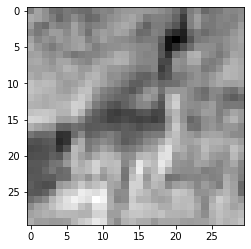

In [16]:
plt.imshow(output[0,0].detach(), cmap = "gray")

In [17]:
conv = nn.Conv2d(3, 1, kernel_size=3, padding=1)
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 1, 32, 32]))

In [18]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

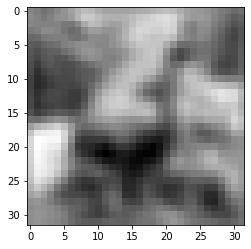

In [19]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap = "gray")

In [20]:
conv = nn.Conv2d(3, 1 , kernel_size=3, padding=1)

with torch.no_grad():
        conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                      [-1.0, 0.0, 1.0],
                                      [-1.0, 0.0, 1.0]])
        conv.bias.zero_()

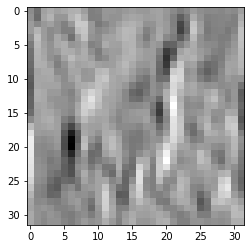

In [21]:
output = conv(img.unsqueeze(0))
plt.imshow(output[0,0].detach(), cmap = "gray")

In [22]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))

img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

In [23]:
model = nn.Sequential(nn.Conv2d(3, 16, kernel_size=3, padding=1),
                     nn.Tanh(),
                     nn.MaxPool2d(2),
                     nn.Conv2d(16, 8, kernel_size=3, padding=1),
                     nn.Tanh(),
                     nn.MaxPool2d(2),
                     nn.Linear(8*8*8,32),
                     nn.Tanh(),
                     nn.Linear(32,2))

In [24]:
numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [26]:
model(img.unsqueeze(0))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x8 and 512x32)

In [27]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.act1 = nn.Tanh()
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.act2 = nn.Tanh()
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.act3 = nn.Tanh()
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, X):
        out = self.pool1(self.act1(self.conv1(x)))
        out = self.pool2(self.act2(self.conv2(out)))
        out = out.view(-1, 8*8*8)
        out = self.act3(self.fc1(out))
        out = self.fc2(out)
        return out

In [28]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

In [31]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8*8*8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1, 8*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [32]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.0368,  0.0620]], grad_fn=<AddmmBackward0>)

In [33]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch %10 == 0:
            print("{} Epoch {}, Training Loss {}".format(datetime.datetime.now(), epoch,
                                                        loss_train/len(train_loader)))

In [34]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net()
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs= 100,
             optimizer= optimizer,
             model=model,
             loss_fn= loss_fn,
             train_loader= train_loader)

2022-08-13 22:54:47.919697 Epoch 1, Training Loss 0.5809889177607882
2022-08-13 22:55:12.578757 Epoch 10, Training Loss 0.331522931433787
2022-08-13 22:55:39.237447 Epoch 20, Training Loss 0.29326378264624603
2022-08-13 22:56:04.930682 Epoch 30, Training Loss 0.2701283608842048
2022-08-13 22:56:31.658183 Epoch 40, Training Loss 0.25200115737451867
2022-08-13 22:56:56.758038 Epoch 50, Training Loss 0.235734957418624
2022-08-13 22:57:21.882826 Epoch 60, Training Loss 0.21668952945501183
2022-08-13 22:57:47.052492 Epoch 70, Training Loss 0.20261107100422976
2022-08-13 22:58:12.608127 Epoch 80, Training Loss 0.18995030703628138
2022-08-13 22:58:37.760840 Epoch 90, Training Loss 0.17355582972241054
2022-08-13 22:59:03.246663 Epoch 100, Training Loss 0.16071408213513672


In [35]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader),("val", val_loader)]:
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim = 1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {} : {:.2f}".format(name, correct/total))
        
validate(model, train_loader, val_loader)

Accuracy train : 0.94
Accuracy val : 0.94


In [36]:
torch.save(model.state_dict(), data_path + "birds_vs_airplanes.pt")

In [37]:
loaded_model = Net()
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt"))

<All keys matched successfully>

In [38]:
device = (torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu'))
print("Training on device {}".format(device))

Training on device cuda


In [53]:
import datetime

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch %10 == 0:
            print("{} Epoch {}, Training Loss {}".format(datetime.datetime.now(), epoch,
                                                        loss_train/len(train_loader)))

In [40]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

model = Net().to(device = device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(n_epochs= 100,
             optimizer= optimizer,
             model=model,
             loss_fn= loss_fn,
             train_loader= train_loader)

2022-08-13 23:10:30.763392 Epoch 1, Training Loss 0.5947305894201729
2022-08-13 23:10:35.627253 Epoch 10, Training Loss 0.3343751464679742
2022-08-13 23:10:40.981385 Epoch 20, Training Loss 0.29927480515021426
2022-08-13 23:10:46.578540 Epoch 30, Training Loss 0.2782207255720333
2022-08-13 23:10:52.535517 Epoch 40, Training Loss 0.25854733927994017
2022-08-13 23:10:58.050429 Epoch 50, Training Loss 0.23661505829566604
2022-08-13 23:11:03.775599 Epoch 60, Training Loss 0.22184188075506003
2022-08-13 23:11:09.770212 Epoch 70, Training Loss 0.2066573816689716
2022-08-13 23:11:15.437216 Epoch 80, Training Loss 0.1920103131301084
2022-08-13 23:11:21.203154 Epoch 90, Training Loss 0.1771387698449147
2022-08-13 23:11:26.711121 Epoch 100, Training Loss 0.16250450334921004


In [41]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    accdict = {}
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())

        print("Accuracy {}: {:.2f}".format(name , correct / total))
        accdict[name] = correct / total
    return accdict

all_acc_dict["baseline"] = validate(model, train_loader, val_loader)

Accuracy train: 0.93
Accuracy val: 0.89


In [42]:
loaded_model = Net().to(device = device)
loaded_model.load_state_dict(torch.load(data_path + "birds_vs_airplanes.pt", map_location=device))

<All keys matched successfully>

In [43]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(16*8*8, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1, 16*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
class NetWidth(nn.Module):
    def __init__(self, n_channels = 32):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear((n_channels//2)*8*8, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = out.view(-1, (self.n_channels//2)*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [47]:
model = NetWidth(n_channels=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-08-14 00:11:31.317784 Epoch 1, Training Loss 0.5684567767723351
2022-08-14 00:11:39.847036 Epoch 10, Training Loss 0.3173149495747439
2022-08-14 00:11:49.443445 Epoch 20, Training Loss 0.27223309295572296
2022-08-14 00:11:59.196988 Epoch 30, Training Loss 0.2395031897790113
2022-08-14 00:12:08.496141 Epoch 40, Training Loss 0.21252204477787018
2022-08-14 00:12:18.025616 Epoch 50, Training Loss 0.18833584352663368
2022-08-14 00:12:27.121547 Epoch 60, Training Loss 0.1648601421457567
2022-08-14 00:12:36.431780 Epoch 70, Training Loss 0.14210019884690359
2022-08-14 00:12:46.259791 Epoch 80, Training Loss 0.12065934370847264
2022-08-14 00:12:55.830095 Epoch 90, Training Loss 0.10120808202654692
2022-08-14 00:13:05.041199 Epoch 100, Training Loss 0.08394192426115464
Accuracy train: 0.97
Accuracy val: 0.89


In [48]:
sum(p.numel() for p in model.parameters())

38386

In [51]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs+1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            imgs = imgs.to(device = device)
            labels = labels.to(device = device)
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
            loss = loss + l2_lambda * l2_norm
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        if epoch == 1 or epoch %10 == 0:
            print("{} Epoch {}, Training Loss {}".format(datetime.datetime.now(),
                                                        epoch,
                                                        loss_train/ len(train_loader)))

In [52]:
model = Net().to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["l2 reg"] = validate(model, train_loader, val_loader)

2022-08-14 00:22:34.114523 Epoch 1, Training Loss 0.5741141920636414
2022-08-14 00:22:45.966875 Epoch 10, Training Loss 0.35711301986578925
2022-08-14 00:22:57.880625 Epoch 20, Training Loss 0.3309832856913281
2022-08-14 00:23:09.874807 Epoch 30, Training Loss 0.3056229800935004
2022-08-14 00:23:21.735838 Epoch 40, Training Loss 0.2807287066985088
2022-08-14 00:23:33.538169 Epoch 50, Training Loss 0.2630868437373714
2022-08-14 00:23:45.360864 Epoch 60, Training Loss 0.2495002414865099
2022-08-14 00:23:57.317961 Epoch 70, Training Loss 0.23852769081379957
2022-08-14 00:24:09.981923 Epoch 80, Training Loss 0.2291918381289312
2022-08-14 00:24:22.196415 Epoch 90, Training Loss 0.220726175055762
2022-08-14 00:24:34.139807 Epoch 100, Training Loss 0.21278903889618103
Accuracy train: 0.90
Accuracy val: 0.87


In [54]:
class NetDropout(nn.Module):
    def __init__(self, n_channels = 32):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear((n_channels//2)*8*8, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)),2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)),2)
        out = self.conv2_dropout(out)
        out = out.view(-1, (self.n_channels//2)*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [56]:
model = NetDropout(n_channels=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-08-14 00:26:45.493277 Epoch 1, Training Loss 0.5692109970530127
2022-08-14 00:26:54.133972 Epoch 10, Training Loss 0.3779181803867316
2022-08-14 00:27:03.667928 Epoch 20, Training Loss 0.3519964409861595
2022-08-14 00:27:13.233460 Epoch 30, Training Loss 0.32873112210042915
2022-08-14 00:27:23.046895 Epoch 40, Training Loss 0.3196288115659337
2022-08-14 00:27:32.573196 Epoch 50, Training Loss 0.3022598986792716
2022-08-14 00:27:42.098221 Epoch 60, Training Loss 0.27974782703788414
2022-08-14 00:27:51.657728 Epoch 70, Training Loss 0.27463412199430404
2022-08-14 00:28:01.256781 Epoch 80, Training Loss 0.2629080816249179
2022-08-14 00:28:11.352113 Epoch 90, Training Loss 0.2584619075059891
2022-08-14 00:28:20.997263 Epoch 100, Training Loss 0.24155848620423845
Accuracy train: 0.90
Accuracy val: 0.88


In [57]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_channels = 32):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_channels)
        self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_channels//2)
        self.fc1 = nn.Linear((n_channels//2)*8*8, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out),2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out),2)
        out = out.view(-1, (self.n_channels//2)*8*8)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [58]:
model = NetBatchNorm(n_channels=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-08-14 00:31:30.741905 Epoch 1, Training Loss 0.45940374132174594
2022-08-14 00:31:41.505331 Epoch 10, Training Loss 0.27189487721889644
2022-08-14 00:31:54.038696 Epoch 20, Training Loss 0.20993076027578608
2022-08-14 00:32:05.709745 Epoch 30, Training Loss 0.16090466504453854
2022-08-14 00:32:18.062126 Epoch 40, Training Loss 0.1182641963100737
2022-08-14 00:32:30.046059 Epoch 50, Training Loss 0.08323708523041123
2022-08-14 00:32:41.720718 Epoch 60, Training Loss 0.0545059246883081
2022-08-14 00:32:53.414636 Epoch 70, Training Loss 0.037404904331845845
2022-08-14 00:33:05.090817 Epoch 80, Training Loss 0.02731997452106825
2022-08-14 00:33:16.999405 Epoch 90, Training Loss 0.015411462966993356
2022-08-14 00:33:29.196087 Epoch 100, Training Loss 0.010125543060564216
Accuracy train: 0.99
Accuracy val: 0.88


In [59]:
class NetDepth(nn.Module):
    def __init__(self, n_channels = 32):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_channels//2, n_channels//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_channels//2, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4*4*self.n_channels//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [60]:
model = NetDepth(n_channels=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-08-14 00:39:33.562595 Epoch 1, Training Loss 0.6896943138663176
2022-08-14 00:39:43.049619 Epoch 10, Training Loss 0.3501787195160131
2022-08-14 00:39:53.543276 Epoch 20, Training Loss 0.3057870450103359
2022-08-14 00:40:04.301534 Epoch 30, Training Loss 0.2728988979082958
2022-08-14 00:40:14.887062 Epoch 40, Training Loss 0.24290042840371465
2022-08-14 00:40:25.604521 Epoch 50, Training Loss 0.21652958067549263
2022-08-14 00:40:36.249652 Epoch 60, Training Loss 0.19297066895635265
2022-08-14 00:40:46.974954 Epoch 70, Training Loss 0.169632156326133
2022-08-14 00:40:57.687195 Epoch 80, Training Loss 0.14657948303754162
2022-08-14 00:41:08.399706 Epoch 90, Training Loss 0.12391081039503121
2022-08-14 00:41:19.150182 Epoch 100, Training Loss 0.09979413625351183
Accuracy train: 0.96
Accuracy val: 0.90


In [61]:
class NetRes(nn.Module):
    def __init__(self, n_channels = 32):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_channels, n_channels//2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_channels//2, n_channels//2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4*4*n_channels//2, 32)
        self.fc2 = nn.Linear(32,2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2)
        out = out.view(-1, 4*4*self.n_channels//2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [62]:
model = NetRes(n_channels=32).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-08-14 00:41:42.459160 Epoch 1, Training Loss 0.6735001289920443
2022-08-14 00:41:52.784234 Epoch 10, Training Loss 0.32570326290312845
2022-08-14 00:42:03.580546 Epoch 20, Training Loss 0.28197954186967983
2022-08-14 00:42:14.367227 Epoch 30, Training Loss 0.2514724030046706
2022-08-14 00:42:25.281193 Epoch 40, Training Loss 0.22231777358776444
2022-08-14 00:42:36.007566 Epoch 50, Training Loss 0.19447387327813798
2022-08-14 00:42:46.744260 Epoch 60, Training Loss 0.16804503421684738
2022-08-14 00:42:57.524616 Epoch 70, Training Loss 0.14211151063157496
2022-08-14 00:43:08.428976 Epoch 80, Training Loss 0.11809557953932483
2022-08-14 00:43:19.318568 Epoch 90, Training Loss 0.0979348948213515
2022-08-14 00:43:30.131187 Epoch 100, Training Loss 0.07285046757786137
Accuracy train: 0.97
Accuracy val: 0.91


In [64]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False)
        self.batch_norm = nn.BatchNorm2d(num_features= n_chans)
        torch.nn.init.kaiming_uniform_(self.conv.weight, nonlinearity='relu')
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)
        
    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

In [65]:
class NetResDeep(nn.Module):
    def __init__(self, n_channels = 32, n_blocks = 10):
        super().__init__()
        self.n_channels = n_channels
        self.conv1 = nn.Conv2d(3, n_channels, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_channels)]))
        self.fc1 = nn.Linear(8*8*n_channels, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)),2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8*8*self.n_channels)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [66]:
model = NetResDeep(n_channels=32, n_blocks=100).to(device=device)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-08-14 00:54:08.764882 Epoch 1, Training Loss 1.2762297697507652
2022-08-14 00:58:22.000076 Epoch 10, Training Loss 0.32585695594739
2022-08-14 01:02:25.450678 Epoch 20, Training Loss 0.2419887431867563
2022-08-14 01:06:28.981198 Epoch 30, Training Loss 0.17353768029790015
2022-08-14 01:10:32.417416 Epoch 40, Training Loss 0.17074300068768727
2022-08-14 01:14:35.952754 Epoch 50, Training Loss 0.1246688063048823
2022-08-14 01:18:39.528935 Epoch 60, Training Loss 0.09902005261818694
2022-08-14 01:22:42.852739 Epoch 70, Training Loss 0.121285844072225
2022-08-14 01:26:46.292022 Epoch 80, Training Loss 0.0577451386533464
2022-08-14 01:30:49.619725 Epoch 90, Training Loss 0.026926622719720458
2022-08-14 01:34:52.964003 Epoch 100, Training Loss 0.014353897450636378
Accuracy train: 0.99
Accuracy val: 0.86


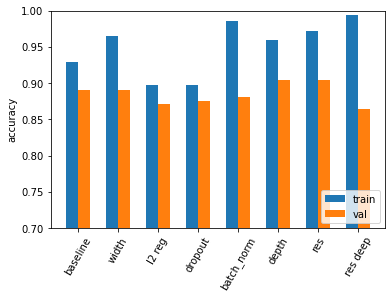

In [67]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]


width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()),
           rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.show()
